In [26]:
# Global imports and settings
from preamble import *
%matplotlib inline
plt.rcParams['savefig.dpi'] = 120 # Use 300 for PDF, 100 for slides
#InteractiveShell.ast_node_interactivity = "all"
HTML('''<style>html, body{overflow-y: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides

# Machine learning pipelines

## Preprocessing

* Many of the algorithms that we've seen are greatly affected by _how_ you represent the training data
* Scaling, numeric/categorical values, missing values, feature selection/construction
* We typically need chain together different algorithms
    - Many preprocessing steps
    - Possibly many models
* This is called a _pipeline_ (or _workflow_)

Outline:
* Examples of which preprocessing steps are best combined with learning algorithm
* How to apply preprocessing techniques
* How to design and optimize pipelines
* Some practical advice

### Categorical Variables
In scikit-learn, all input features have to be numeric. 

#### One-Hot-Encoding (Dummy variables)
Convert a feature with c categories to $c$ dummy variables:  

Load some data with categorical values

In [27]:
import os
# The file has no headers naming the columns, so we pass header=None
# and provide the column names explicitly in "names"
data = pd.read_csv(
    os.path.join(mglearn.datasets.DATA_FOLDER, "adult.data"), header=None, index_col=False,
    names=['age', 'workclass', 'fnlwgt', 'education',  'education-num',
           'marital-status', 'occupation', 'relationship', 'race', 'gender',
           'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
           'income'])
# For illustration purposes, we only select some of the columns:
data = data[['age', 'workclass', 'education', 'gender', 'hours-per-week',
             'occupation', 'income']]
# IPython.display allows nice output formatting within the Jupyter notebook
display(data.head())

,age,workclass,education,gender,hours-per-week,occupation,income
0,39,State-gov,Bachelors,Male,40,Adm-clerical,<=50K
1,50,Self-emp-not-inc,Bachelors,Male,13,Exec-managerial,<=50K
2,38,Private,HS-grad,Male,40,Handlers-cleaners,<=50K
3,53,Private,11th,Male,40,Handlers-cleaners,<=50K
4,28,Private,Bachelors,Female,40,Prof-specialty,<=50K


##### Sanity checking string-encoded categorical data

It might be that some people specified gender as “male” and some as “man” by mistake

Check the contents of a column by using the value_counts function of a pandas Series:

In [28]:
print(data.gender.value_counts())

 Male      21790
 Female    10771
Name: gender, dtype: int64


#### Encoding data in pandas (`get_dummies`)  

Automatically transforms all columns that have object type (like strings) or are categorical.

In [29]:
print("Original features:\n", list(data.columns), "\n") 
data_dummies = pd.get_dummies(data)
print("Features after get_dummies:\n", list(data_dummies.columns))

Original features:
 ['age', 'workclass', 'education', 'gender', 'hours-per-week', 'occupation', 'income'] 

Features after get_dummies:
 ['age', 'hours-per-week', 'workclass_ ?', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Never-worked', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_ 10th', 'education_ 11th', 'education_ 12th', 'education_ 1st-4th', 'education_ 5th-6th', 'education_ 7th-8th', 'education_ 9th', 'education_ Assoc-acdm', 'education_ Assoc-voc', 'education_ Bachelors', 'education_ Doctorate', 'education_ HS-grad', 'education_ Masters', 'education_ Preschool', 'education_ Prof-school', 'education_ Some-college', 'gender_ Female', 'gender_ Male', 'occupation_ ?', 'occupation_ Adm-clerical', 'occupation_ Armed-Forces', 'occupation_ Craft-repair', 'occupation_ Exec-managerial', 'occupation_ Farming-fishing', 'occupation_ Handlers-cleaners', 'occupation_ Machine-op-i

In [30]:
display(data_dummies.head(n=2))

,age,hours-per-week,workclass_ ?,workclass_ Federal-gov,...,occupation_ Tech-support,occupation_ Transport-moving,income_ <=50K,income_ >50K
0,39,40,0,0,...,0,0,1,0
1,50,13,0,0,...,0,0,1,0


Next step: Convert the data_dummies DataFrame into a NumPy array, and then train a machine learning model on it. 

Be careful to separate the target variable (which is now encoded in two income columns) from the data before training a model.

In [31]:
# Get only the columns containing features
# that is all columns from 'age' to 'occupation_ Transport-moving'
# This range contains all the features but not the target

features = data_dummies.ix[:, 'age':'occupation_ Transport-moving']
# extract NumPy arrays
X = features.values
y = data_dummies['income_ >50K'].values
print("X.shape: {}  y.shape: {}".format(X.shape, y.shape))

X.shape: (32561, 44)  y.shape: (32561,)


Now the data is represented in a way that scikit-learn can work with, and we can
proceed as usual:

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print("Test score: {:.2f}".format(logreg.score(X_test, y_test)))

Test score: 0.81


#### Integers can encode categories

Categorical variables are sometimes pre-encoded as integers (e.g. 0=green, 1=blue). They should not be encoded as a single continuous variable.

To get around this, you need to convert numeric columns in the DataFrame to strings.

In [33]:
# create a dataframe with an integer feature and a categorical string feature
demo_df = pd.DataFrame({'Integer Feature': [0, 1, 2, 1],
                        'Categorical Feature': ['socks', 'fox', 'socks', 'box']})
display(demo_df)

,Categorical Feature,Integer Feature
0,socks,0
1,fox,1
2,socks,2
3,box,1


In [34]:
display(pd.get_dummies(demo_df))

,Integer Feature,Categorical Feature_box,Categorical Feature_fox,Categorical Feature_socks
0,0,0,0,1
1,1,0,1,0
2,2,0,0,1
3,1,1,0,0


In [35]:
demo_df['Integer Feature'] = demo_df['Integer Feature'].astype(str)
display(pd.get_dummies(demo_df, columns=['Integer Feature', 'Categorical Feature']))

,Integer Feature_0,Integer Feature_1,Integer Feature_2,Categorical Feature_box,Categorical Feature_fox,Categorical Feature_socks
0,1,0,0,0,0,1
1,0,1,0,0,1,0
2,0,0,1,0,0,1
3,0,1,0,1,0,0


### Applying data transformations in scikit-learn

- First, we `fit` the preprocessor on the __training data__
    - This computes the necessary transformation parameters
    - For `OneHotEncoder`, this simply remembers which features are categorical
- Second, we use the fitted preprocessor to `transform` __training data__ and the __test data__
    - No information should `leak` from the test data into the training data
- You can fit and transform the training together with `fit_transform`

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target,
                                                    random_state=0)
encoder = OneHotEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

### Transformation techniques

Many transformation techniques can be used in pipelines.
* `OneHotEncoder`: convert categorical to numeric features
* `np.digitize`: discretization (binning) of numeric features
* `PolynomialFeatures`: construct all interactions with polynomials up to a given degree
* `SelectPercentile`: use ANOVA to select most informative features
* `SelectFromModel(RandomForestClassifier())`: model-based feature selection
* `RFE`: recursive feature elimination
* `VarianceThreshold`: removes low-variance (e.g. constant) features

#### Missing value imputation
* Many sci-kit learn algorithms cannot handle missing value
* `Imputer` replaces specific values
    * `missing_values` (default 'NaN') placeholder for the missing value
    * `strategy`:
        - `mean`, replace using the mean along the axis
        - `median`, replace using the median along the axis
        - `most_frequent`, replace using the most frequent value
* Many more advanced techniques exist, but not yet in scikit-learn
    * e.g. low rank approximations (uses matrix factorization)

In [37]:
from sklearn.preprocessing import Imputer
X1_train = [[1, 2], [np.nan, 3], [7, 6]];
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(X1_train)
X1 = [[np.nan, 2], [6, np.nan], [7, 6]]
print("Missing data: {}".format(X1) )                          
print("Imputed data:\n {}".format(imp.transform(X1))  )                         

Missing data: [[nan, 2], [6, nan], [7, 6]]
Imputed data:
 [[ 4.     2.   ]
 [ 6.     3.667]
 [ 7.     6.   ]]


#### Dimensionality reduction techniques 
- Many techniques
    - `decomposition.PCA` (Principal Component Analysis)
    - `manifold.MDS` (Multi-Dimensional Scaling)
    - `manifold.Isomap`
    - `random_projection.GaussianRandomProjection`
    - `random_projection.johnson_lindenstrauss_min_dim`
    - ...
- See coming lectures
- Reducing the number of features greatly helps distance-based algorithms (kNN, clustering,...)
    - Curse of dimensionality (Bellman's curse): for every new feature, we need exponentially more data
- Very useful in their own right 
- Note: not all dimensionality reduction techniques can be used as a transformer. 
    - They have a `fit`, but no `transform` method, and can't be applied on test data.

## Hyperparameter Selection with Preprocessing 
* If we also want to optimize our SVM's hyperparameters, things get more complicated
* Indeed, when we `fit` the preprocessor (`MinMaxScaler`), we used _all_ the training data.
* The cross-validation splits in GridSearchCV will have training sets preprocessed with information from the test sets (data leakage)

In [40]:
from sklearn.model_selection import GridSearchCV
# illustration purposes only, don't use this code
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Best set score: {:.2f}".format(grid.score(X_test_scaled, y_test)))
print("Best parameters: ", grid.best_params_)

Best cross-validation accuracy: 0.98
Best set score: 0.97
Best parameters:  {'C': 1, 'gamma': 1}


Visualization of what happens in this code
* During cross-validation (grid search) we evaluate hyperparameter settings on a validation set that was preprocessed with information in that validation set
* This will lead to overly optimistic results during cross-validation
* When we want to use the optimized hyperparameters on the held-out test data, the selected hyperparameters may be suboptimal.
* To solve this, we need to _glue_ the preprocessing and learning algorithms together by building a pipeline

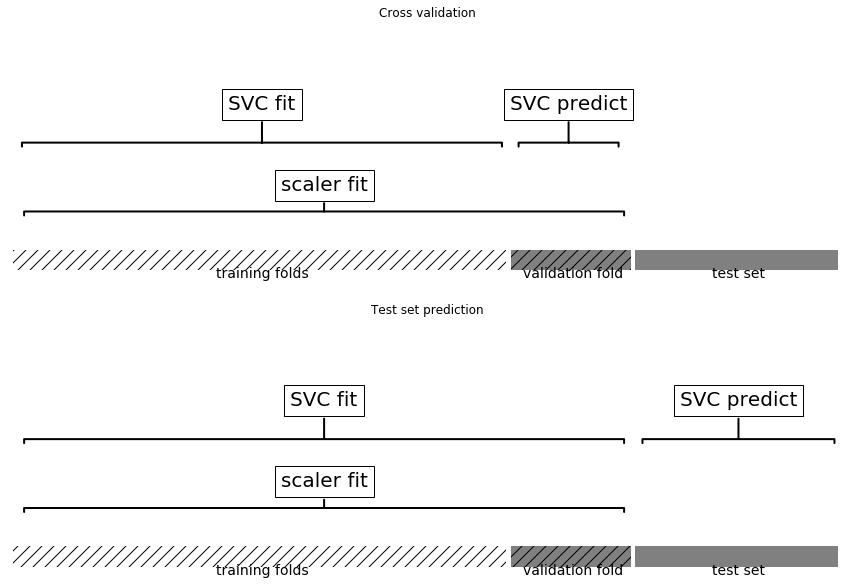

In [41]:
mglearn.plots.plot_improper_processing()

### Using Pipelines in Grid-searches
* We can use the pipeline as a single estimator in `cross_val_score` or `GridSearchCV`
* To define a grid, refer to the hyperparameters of the steps
    * Step `svm`, parameter `C` becomes `svm__C`

In [42]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

In [43]:
from sklearn import pipeline

pipe = pipeline.Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 0.98
Test set score: 0.97
Best parameters: {'svm__C': 1, 'svm__gamma': 1}


* Now, the preprocessors are refit with only the training data in each cross-validation split.

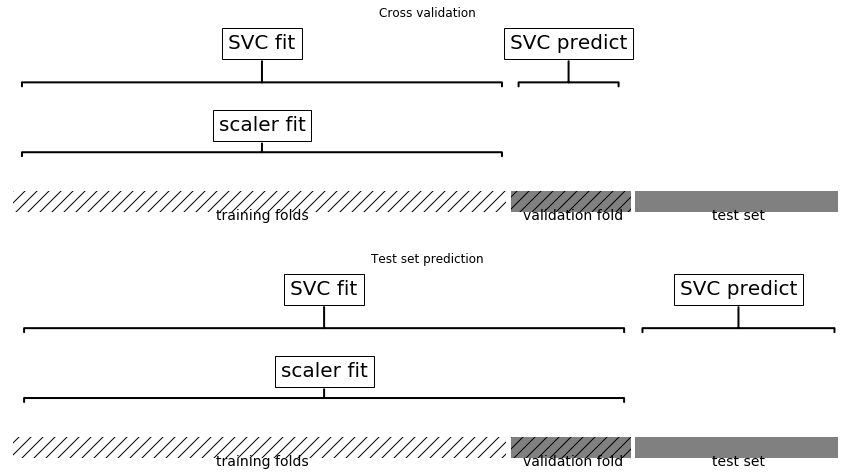

In [44]:
mglearn.plots.plot_proper_processing()

* When we request the best estimator of the grid search, we'll get the best pipeline

In [45]:
print("Best estimator:\n{}".format(grid.best_estimator_))

Best estimator:
Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svm', SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])


* And we can drill down to individual components and their properties

In [46]:
# Get the SVM
print("SVM step:\n{}".format(
      grid.best_estimator_.named_steps["svm"]))

SVM step:
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [47]:
# Get the SVM dual coefficients (support vector weights)
print("SVM support vector coefficients:\n{}".format(
      grid.best_estimator_.named_steps["svm"].dual_coef_))

SVM support vector coefficients:
[[-1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -0.822 -0.609
  -0.93  -1.    -0.665 -1.    -0.793 -1.    -1.    -1.    -1.    -1.    -1.
  -0.63  -1.    -1.    -1.    -0.166 -0.575 -1.    -0.119 -1.    -0.38  -1.
  -0.55  -0.048 -0.606 -1.    -0.071 -1.    -0.126 -0.106 -0.285 -1.    -1.
  -1.    -0.46   1.     0.932  1.     1.     0.901  1.     0.911  1.     1.
   1.     0.653  1.     1.     0.953  0.577  1.     1.     1.     1.     1.
   0.659  1.     1.     0.757  1.     1.     1.     1.     1.     1.     1.
   0.096  0.274  0.329  1.     1.     1.     0.491  1.     0.41 ]]


### Information leakage 

* See 'Elements of statistical learning' for a great example of data leakage
* Consider a synthetic regression task with 100 samples and 10,000 features with data and labels independently sampled from a Gaussian distribution
    * Hence, there should be no relation between the data `X` and target `y`

In [48]:
rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100, 10000))
y = rnd.normal(size=(100,))

* First, we select the 5% most informative features with `SelectPercentile`, and then evaluate a `Ridge` regressor

In [49]:
from sklearn.feature_selection import SelectPercentile, f_regression

select = SelectPercentile(score_func=f_regression, percentile=5).fit(X, y)
X_selected = select.transform(X)
print("X_selected.shape: {}".format(X_selected.shape))

X_selected.shape: (100, 500)


In [50]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
print("Cross-validation accuracy (cv only on ridge): {:.2f}".format(
      np.mean(cross_val_score(Ridge(), X_selected, y, cv=5))))

Cross-validation accuracy (cv only on ridge): 0.91


* The $R^{2}$ performance is 0.91 (a very good model). This can't be right given that our data is random.
* Our feature selection picked out some of the random features which (by chance) correlated with the random target.
* Because we selected the features _outside_ of the cross-validation, it could find features that are correlated on the samples in the test folds.
* Hence, information leaked from the test set into the training set (through the selection of features).

* Now, let's do a proper cross-validation using a pipeline:

In [51]:
pipe = pipeline.Pipeline([("select", SelectPercentile(score_func=f_regression,
                                             percentile=5)),
                 ("ridge", Ridge())])
print("Cross-validation accuracy (pipeline): {:.2f}".format(
      np.mean(cross_val_score(pipe, X, y, cv=5))))

Cross-validation accuracy (pipeline): -0.25


* We get a negative $R^2$ score (a very poor model), as expected.
* The feature selection now happens _inside_ the cross-validation loop, using only the training folds.
* It will still find features that correlate with the labels in the training data, but not with those in the test data.

### Grid-searching preprocessing steps and model parameters
* We can use grid search to optimize the hyperparameters of our preprocessing steps and learning algorithms at the same time
* Consider the following pipeline:
    - `StandardScaler`, without hyperparameters
    - `PolynomialFeatures`, with the max. _degree_ of polynomials
    - `Ridge` regression, with L2 regularization parameter _alpha_

In [52]:
from sklearn.datasets import load_boston
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target,
                                                    random_state=0)
from sklearn.preprocessing import PolynomialFeatures
pipe = pipeline.make_pipeline(
    StandardScaler(),
    PolynomialFeatures(),
    Ridge())

* We don't know the optimal polynomial degree or alpha value, so we use a grid search (or random search) to find the optimal values

In [53]:
param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
# Note: I had to use n_jobs=1. (n_jobs=-1 stalls on my machine)
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'polynomialfeatures__degree': [1, 2, 3], 'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

* Visualing the $R^2$ results as a heatmap:

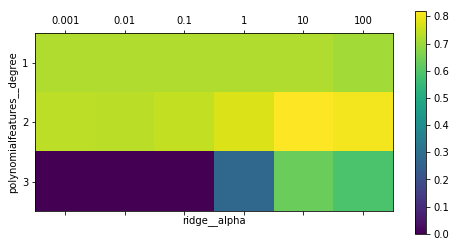

In [54]:
plt.matshow(grid.cv_results_['mean_test_score'].reshape(3, -1),
            vmin=0, cmap="viridis")
plt.xlabel("ridge__alpha")
plt.ylabel("polynomialfeatures__degree")
plt.xticks(range(len(param_grid['ridge__alpha'])), param_grid['ridge__alpha'])
plt.yticks(range(len(param_grid['polynomialfeatures__degree'])),
           param_grid['polynomialfeatures__degree'])

plt.colorbar();

* Here, degree-2 polynomials help (but degree-3 ones don't), and tuning the alpha parameter helps as well.
* Not using the polynomial features leads to suboptimal results (see the results for degree 1)

In [55]:
print("Best parameters: {}".format(grid.best_params_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Best parameters: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}
Test-set score: 0.77


## Algorithm selection
* It is also possible to use a grid search to consider various alternative algorithms for a specific step, and tune the pipelines as well
    - StandardScaler or MinMaxScaler?
    - RandomForest or SVM?
* Note that the search space quickly becomes huge

* As an example, let's consider a pipeline that explores:
    - StandardScaler + SVM, varying `gamma` and `C`
    - None + RandomForest, varying `max_features`
* We instantiate a general pipeline, and define everything else in the grid
    - We need to define a list of 2 grids because of dependencies.

In [56]:
pipe = pipeline.Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

In [57]:
from sklearn.ensemble import RandomForestClassifier

param_grid = [
    {'classifier': [SVC()], 'preprocessing': [StandardScaler(), None],
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier': [RandomForestClassifier(n_estimators=100)],
     'preprocessing': [None], 'classifier__max_features': [1, 2, 3]}]

The Scaling+SVM pipeline wins!

In [58]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Best params:
{'classifier': SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}

Best cross-validation score: 0.99
Test-set score: 0.98


### Algorithm selection: the road ahead
_Automating_ the construction of machine learning pipelines is a hot topic of research, with different possible solutions:

* Model-based optimization: search large algorithm+hyperparameter spaces more effectively (limited to the learning step)
    - E.g. `Auto-SKLearn` and `Hyperopt-SKLearn`
* Multi-armed bandits and Racing: train algorithms first on a small sample, train the best 50% on a larger sample, continue until full dataset
* Genetic programming: very good at exploring large spaces
    - E.g. `sklearn-deap` or `TPOT` (builds pipelines as well)
* Meta-learning: build _meta-models_ to predict which algorithms/hyperparameter ranges are most useful on new datasets
    - Requires large amounts of observations on previous datasets, as well as measureable dataset properties (meta-features) -> OpenML
* Combinations of the above
    - Especially meta-learning with all others
    - Contact me if interested :)

## Approaching machine learning problems

* Just running your favourite algorithm on every new problem is usually not a great way to start
* Consider the problem at large
    - Do you want exploratory analysis or (black box) modelling?
    - How to define and measure success? Are there costs involved?
    - Do you have the right data? How can you make it better?
* Build prototypes early-on to evaluate the above.
* Analyse your model's mistakes
    - Should you collect more, or additional data?
    - Should the task be reformulated?
    - Often a higher payoff than endless grid searching
* Technical debt
    - Very complex machine learning prototypes are hard/impossible to put into practice
    - There is a creation-maintenance trade-off
    - See 'Machine Learning: The High Interest Credit Card of Technical Debt'

### Concept drift
* Data is often a stream, and model building is often part of a feedback cycle
    - Collect new data, cleaning, build models, analyse
    - Continually check that your model is still working
* Concept drift: sudden or gradual changes in the phenomenon that you want to model
    - External: market/weather evolutions, human behavior
    - Feedback: your predictions (and actions) may change future data
        - E.g. movie recommendations, new drugs, treatments, ...
* Different ways to tackle this:
    - Repeated retraining (but often not sure when)
    - Stream mining algorithms (learn on fast streaming data)
    - Change detection techniques (retrain when model starts failing)
    - Meta-learning (switch algorithms depending on data properties)

### Real world evaluations
* Accuracy is seldomly the right measure. Usually, costs are involved.
* Don't just evaluate your predictions themselves, also evaluate how the outcome improves _after_ you take actions based on them
* Beware of non-representative samples. You often don't have the data you really need.
* Adversarial situations (e.g. spam filtering) can subvert your predictions
* Data leakage: the signal your model found was just an artifact of your data
    - See 'Why Should I Trust You?' by Marco Ribeiro et al.
* A/B testing to evaluate algorithms in the wild
    - More advanced: bandit algorithms

### Further reading (Theory)
* The Elements of Statistical Learning (Hastie, Tibshirani, Friedman)
* Deep Learning (Goodfellow, Bengio, Courville) - see later
* Gaussian Processes for Machine Learning (Rasmussen, Williams)
* Machine Learning: An Algorithmic Perspective (Marsland)
* Pattern Recognition and Machine Learning (Bishop)
* Machine Learning: A Probabilistic Perspective (Murphy)
* Foundations of Data Science (Blum, Hopcroft, Kannan)

### Other packages
* Deep learning: `TensorFlow`, `Torch`, `Caffe`,...
    - `Keras`, `Lasagne` provide simpler interfaces
* R libraries often provide a richer variation of techniques
    - Powerful statistical analysis and visualization tools
    - mlr (Machine Learning in R)
* `vowpal wabbit` (vw): C++ library for large datasets and streaming data
* MOA (Massive Online Analysis): Java library for streaming data
* MLLib: Scala library on top of Spark, for large distributed systems
* PyMC/Stan: Probabilistic programming, allows to model how likely each data point is correct. Simple, elegant way to build models.

## Summary

* Pipelines allow us to encapsulate multiple steps into a single estimator
    - Has `fit`, `transform`, and `predict` methods
* Avoids data leakage, hence crucial for proper evaluation
* Choosing the right combination of feature extraction, preprocessing, and models is somewhat of an art.
* Pipelines + Grid/Random Search help, but search space is huge
    - Smarter techniques are being researched
* Real world applications require careful thought, prototyping, and tireless evaluation.   